In [4]:
print("test")

test


In [5]:
home_path = '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/'

# Analysis

In [6]:
import pandas as pd
# from LabData.DataLoaders.GutMBLoader import GutMBLoader
# from LabData.DataLoaders.SubjectLoader import SubjectLoader
# from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
# from LabData.DataAnalyses.TenK_Trajectories.utils import get_diet_logging_around_stage
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import re
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb
import math
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [7]:
single_style = "nature_single.mplstyle"
double_style = "nature_double.mplstyle"
third_style = "nature_third.mplstyle"
plt.rcParams["figure.dpi"] = 150
plt.style.use(single_style)
palette = sns.color_palette("Set2", n_colors=8)

In [8]:
def read_results(df):
    output = []
    for col in df.columns:
        output.append(df[col])
    return tuple(output)

In [9]:
diet_mb = pd.read_pickle(home_path + "data/segal_species/diet_mb_pathways.pkl")
with open(home_path + 'data/segal_species/my_lists_pathways.pkl', 'rb') as file:
    loaded_lists = pickle.load(file)
base_features, all_features, targets = loaded_lists
targets_reformatted = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in targets]
with open(home_path + 'data/segal_species/scaler_pathways.pkl', 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)
diet_mb

,Acorn squash,Alfalfa sprouts,Almond Beverage,Almond flour,Almond spread,Almonds,Amba,Apple,Apple Cake,Apple Vinegar,...,SER-GLYSYN-PWY: superpathway of L-serine and glycine biosynthesis I,SO4ASSIM-PWY: assimilatory sulfate reduction I,SULFATE-CYS-PWY: superpathway of sulfate assimilation and cysteine biosynthesis,TCA-GLYOX-BYPASS: superpathway of glyoxylate bypass and TCA,TCA: TCA cycle I (prokaryotic),THISYNARA-PWY: superpathway of thiamine diphosphate biosynthesis III (eukaryotes),THRESYN-PWY: superpathway of L-threonine biosynthesis,TRNA-CHARGING-PWY: tRNA charging,UDPNAGSYN-PWY: UDP-N-acetyl-D-glucosamine biosynthesis I,VALSYN-PWY: L-valine biosynthesis
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.016416,0.000000,0.0,...,0.009536,0.000000,0.000000,0.000000,0.000000,0.002205,0.008973,0.012579,0.002074,0.015673
10K_1001201093,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.013895,0.000000,0.0,...,0.010022,0.000000,0.000000,0.000000,0.000000,0.006497,0.006011,0.011701,0.001115,0.016344
10K_1002254441,0.0,0.0,0.0,0.0,0.0,0.081238,0.0,0.000000,0.000000,0.0,...,0.006122,0.000000,0.000000,0.000000,0.000000,0.001063,0.006368,0.010865,0.005072,0.018794
10K_1003113258,0.0,0.0,0.0,0.0,0.0,0.002048,0.0,0.008929,0.000000,0.0,...,0.004102,0.000000,0.000000,0.000000,0.000000,0.001092,0.005317,0.023664,0.008836,0.014888
10K_1007330152,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.013066,0.000000,0.000000,0.000000,0.000000,0.002455,0.006434,0.013101,0.003003,0.016973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9996884777,0.0,0.0,0.0,0.0,0.0,0.002401,0.0,0.000000,0.000000,0.0,...,0.005518,0.000000,0.000000,0.000000,0.000000,0.000106,0.006608,0.020721,0.007442,0.016000
10K_9998420917,0.0,0.0,0.0,0.0,0.0,0.019995,0.0,0.018783,0.000000,0.0,...,0.006877,0.000000,0.000000,0.000000,0.000000,0.001785,0.007174,0.018449,0.004949,0.013831
10K_9998635752,0.0,0.0,0.0,0.0,0.0,0.001607,0.0,0.011305,0.000000,0.0,...,0.004144,0.000544,0.000801,0.000000,0.000000,0.001716,0.002874,0.017149,0.002172,0.023256


## Pathways Targets

### Age and Gender

In [10]:
lgbm_base_scores, lgbm_base_pvalues, lgbm_base_coefs, lgbm_base_preds, lgbm_base_targets = read_results(pd.read_pickle(home_path + "data/regression/segal_species/output_base_LGBM_pathways.pkl"))
lgbm_base_scores

0      0.029322
1      0.021157
2      0.040059
3      0.134936
4      0.106804
         ...   
315    0.079584
316    0.106306
317    0.057259
318    0.086431
319    0.171351
Name: 0, Length: 320, dtype: float64

In [11]:
ridge_base_scores, ridge_base_pvalues, ridge_base_coefs, ridge_base_preds, ridge_base_targets = read_results(pd.read_pickle(home_path + "data/regression/segal_species/output_base_ridge_pathways.pkl"))
ridge_base_scores

0      0.050917
1      0.043010
2      0.052707
3      0.142893
4      0.110968
         ...   
315    0.098374
316    0.120656
317    0.050127
318    0.072393
319    0.174249
Name: 0, Length: 320, dtype: float64

### Diet

In [12]:
lgbm_diet_scores, lgbm_diet_pvalues, lgbm_diet_coefs, lgbm_diet_preds, lgbm_diet_targets = read_results(pd.read_pickle(home_path + "data/regression/segal_species/output_LGBM_pathways.pkl"))
print(lgbm_diet_scores)

0      0.135151
1      0.048667
2      0.119027
3      0.166101
4      0.109449
         ...   
315    0.114415
316    0.152933
317    0.111394
318    0.123036
319    0.214633
Name: 0, Length: 320, dtype: float64


In [13]:
lgbm_diet_scores = pd.Series(lgbm_diet_scores)
lgbm_diet_scores.describe()

count    320.000000
mean       0.106651
std        0.050336
min       -0.003213
25%        0.073319
50%        0.093596
75%        0.135233
max        0.251534
Name: 0, dtype: float64

### Choose Significant Targets without permutations

In [14]:
# # How many predictions were statistically significant?
# signifancts = lgbm_diet_pvalues[lgbm_diet_pvalues < 0.05].shape[0]
# print("{} significant predictions ({}%)".format(signifancts, round((signifancts/len(lgbm_diet_pvalues))*100), 2))

In [15]:
# lgbm_diet_pvalues.isna().sum()

In [16]:
# lgbm_diet_pvalues_adj = multipletests(lgbm_diet_pvalues, method='fdr_bh', alpha=0.05)[1]
# lgbm_diet_pvalues_adj = pd.Series(lgbm_diet_pvalues_adj)
# pd.Series(lgbm_diet_pvalues_adj).sort_values()


In [17]:
# # How many predictions were statistically significant after adjustment?
# significants_adj = lgbm_diet_pvalues_adj[lgbm_diet_pvalues_adj < 0.05].shape[0]
# print("{} significant predictions ({}%) after adjustment.".format(significants_adj, round((signifancts/len(lgbm_diet_pvalues_adj))*100), 2))

In [18]:
# significant_targets = [target for target, p_adj in zip(targets, lgbm_diet_pvalues_adj) if p_adj < 0.05]
# print(targets)
# print(len(targets))
# print(significant_targets)
# print(len(significant_targets))


In [19]:
# significant_targets_index = [index for index, (target, p_adj) in enumerate(zip(targets, lgbm_diet_pvalues_adj)) if p_adj < 0.05]
# print(targets)
# print(significant_targets_index)


In [20]:
# with open(home_path + 'data/regression/segal_species/significant_targets_pathways.pkl', 'wb') as file:
#     pickle.dump(significant_targets, file)

In [21]:
# matched_data = pd.DataFrame({'scores': lgbm_diet_scores, 'pvalues_adj': lgbm_diet_pvalues_adj}).dropna()
# non_significant_scores = matched_data.loc[matched_data['pvalues_adj'] >= 0.05, 'scores']
# percentile_99 = np.percentile(non_significant_scores, 99)
# print("99th percentile of non-significant scores:", percentile_99)

### Continue

In [22]:
ridge_diet_scores, ridge_diet_pvalues, ridge_diet_coefs, ridge_diet_preds, ridge_diet_targets = read_results(pd.read_pickle(home_path + "data/regression/segal_species/output_ridge_pathways.pkl"))
print(ridge_diet_scores)

0      0.081820
1      0.049924
2      0.078012
3      0.104863
4      0.047823
         ...   
315    0.065577
316    0.078580
317    0.079168
318    0.080673
319    0.153537
Name: 0, Length: 320, dtype: float64


In [23]:
ridge_diet_scores = pd.Series(ridge_diet_scores)
ridge_diet_scores.describe()

count    320.000000
mean       0.063116
std        0.035821
min       -0.010291
25%        0.041652
50%        0.054134
75%        0.080686
max        0.187387
Name: 0, dtype: float64

In [24]:
# How many predictions were statistically significant?
signifancts = ridge_diet_pvalues[ridge_diet_pvalues < 0.05].shape[0]
print("{} significant predictions ({}%)".format(signifancts, round((signifancts/len(lgbm_diet_pvalues))*100), 2))

292 significant predictions (91%)


In [25]:
# Improvement from linear to LGBM
delta = pd.Series(lgbm_diet_scores) - pd.Series(ridge_diet_scores)
delta.describe()

count    320.000000
mean       0.043535
std        0.020751
min       -0.025542
25%        0.032027
50%        0.044334
75%        0.059253
max        0.089377
Name: 0, dtype: float64

In [26]:
print("Improvement median:", delta.median())

Improvement median: 0.04433354390880711


In [27]:
print("Number of microbes with better LGBM prediction: ", delta[delta > 0].shape[0])
print("Number of microbes with better Linear prediction: ", delta[delta < 0].shape[0])

Number of microbes with better LGBM prediction:  309
Number of microbes with better Linear prediction:  11


Predictive gain

In [28]:
# Improvement from base features to full features
predictive_gains = pd.Series(lgbm_diet_scores) - pd.Series(lgbm_base_scores)
predictive_gains.describe()

count    320.000000
mean       0.020431
std        0.042519
min       -0.053642
25%       -0.018136
50%        0.020197
75%        0.043905
max        0.173891
Name: 0, dtype: float64

In [29]:
print("Improvement median:", predictive_gains.median())

Improvement median: 0.020196830326886822


In [30]:
top_microbes = predictive_gains.sort_values(ascending=False)
top_microbes = top_microbes[top_microbes > 0.1]
top_microbes

20     0.173891
94     0.160278
170    0.150536
276    0.146421
41     0.144909
177    0.133192
204    0.131152
233    0.129190
35     0.124459
270    0.114154
6      0.106478
0      0.105829
168    0.104973
179    0.102430
63     0.101272
Name: 0, dtype: float64

In [31]:
# for summary plot
list(top_microbes.index)

[20, 94, 170, 276, 41, 177, 204, 233, 35, 270, 6, 0, 168, 179, 63]

## Permutations
In order to find out the size of a significant correlation. 

In [32]:
# # lgbm_div_perm_scores, lgbm_div_perm_pvalues = read_results(pd.read_pickle(home_path +f"data/regression/segal_species/lightGBM_output_diversity_perm.pkl"))
lgbm_microbes_perm = pd.read_pickle(home_path +f"data/regression/segal_species/output_LGBM_pathways_perm.pkl")
permutation_scores = lgbm_microbes_perm
permutation_scores

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1CMET2_PWY__folate_transformations_III__E__coli_,0.008604,0.015245,-0.036738,-0.002670,-0.012658,-0.014582,-0.040033,0.008274,-0.011793,-0.007340,...,-0.015802,-1.563608e-02,-0.009504,0.025912,0.008959,-0.002095,0.002770,0.011452,0.023627,-0.029704
ALLANTOINDEG_PWY__superpathway_of_allantoin_degradation_in_yeast,0.000745,0.007057,-0.013224,0.013705,0.022986,-0.004411,-0.009891,-0.006320,0.033766,-0.016884,...,-0.004535,-5.339438e-03,-0.010410,-0.005838,-0.026688,0.014487,-0.013320,0.000833,-0.009023,-0.028204
ANAEROFRUCAT_PWY__homolactic_fermentation,0.003370,0.014322,-0.022277,-0.003145,0.011440,-0.014836,-0.004486,-0.000463,-0.014528,-0.000590,...,-0.014723,-1.659059e-02,0.019870,0.004501,0.001890,-0.023942,0.006854,0.006249,-0.006465,-0.006426
ARG_POLYAMINE_SYN__superpathway_of_arginine_and_polyamine_biosynthesis,-0.003685,-0.018055,0.003217,-0.012282,-0.000865,-0.022079,0.010140,-0.014914,-0.002430,-0.008398,...,0.008981,1.143388e-02,-0.001106,-0.001431,0.008840,-0.009076,-0.000777,0.002801,-0.015084,-0.033860
BIOTIN_BIOSYNTHESIS_PWY__biotin_biosynthesis_I,-0.038842,-0.003578,-0.015776,-0.039381,0.012433,-0.010325,0.018023,0.003710,0.017079,0.006138,...,0.046842,-1.145510e-02,-0.038679,-0.015967,-0.017603,-0.016895,0.001803,0.000087,0.003249,-0.003599
COLANSYN_PWY__colanic_acid_building_blocks_biosynthesis,0.009410,-0.003107,0.002066,-0.006190,0.005328,-0.023337,-0.027272,0.001113,0.016094,-0.000426,...,-0.014585,4.361561e-02,-0.023682,-0.025575,-0.017998,-0.025031,-0.026274,-0.005925,0.016482,-0.046456
DAPLYSINESYN_PWY__L_lysine_biosynthesis_I,0.010527,0.016745,0.008924,-0.010294,0.027560,-0.026740,-0.020866,-0.023594,-0.014257,-0.021049,...,0.002804,1.073269e-02,0.014094,-0.014407,0.010861,-0.008067,-0.007549,-0.033530,-0.013198,-0.021675
FAO_PWY__fatty_acid__beta__oxidation_I__generic_,0.001713,-0.011952,-0.003027,-0.008241,-0.017046,-0.006174,-0.001402,-0.009626,0.010577,0.005235,...,0.011786,3.333532e-02,-0.014653,-0.007114,0.008164,-0.004235,-0.003476,-0.019881,0.002278,-0.010620
GALACT_GLUCUROCAT_PWY__superpathway_of_hexuronide_and_hexuronate_degradation,-0.004655,-0.040076,0.002608,-0.010700,-0.004671,0.023598,-0.000076,-0.012846,0.016214,-0.011749,...,0.005133,-1.658787e-02,-0.018786,0.004047,-0.002789,-0.005533,-0.006925,0.011932,-0.018169,-0.011072
GALACTITOLCAT_PWY__galactitol_degradation,0.011275,-0.003407,-0.005268,-0.006416,0.015630,-0.001859,0.001229,-0.014500,0.001339,-0.000188,...,-0.000880,7.604978e-03,-0.013226,-0.000452,-0.008097,-0.013266,-0.011627,-0.002529,0.030661,-0.015503


In [33]:
with open(f"/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/regression/segal_species/microbe_bin_mapping_perm_pathways.pkl", 'rb') as f:
    microbe_bin_mapping = pickle.load(f)
microbe_bin_mapping

{'1CMET2_PWY__folate_transformations_III__E__coli_': 95,
 'ALLANTOINDEG_PWY__superpathway_of_allantoin_degradation_in_yeast': 5,
 'ANAEROFRUCAT_PWY__homolactic_fermentation': 90,
 'ANAGLYCOLYSIS_PWY__glycolysis_III__from_glucose_': 95,
 'ARG_POLYAMINE_SYN__superpathway_of_arginine_and_polyamine_biosynthesis': 20,
 'ARGININE_SYN4_PWY__L_ornithine_biosynthesis_II': 95,
 'ARGSYN_PWY__L_arginine_biosynthesis_I__via_L_ornithine_': 95,
 'ARGSYNBSUB_PWY__L_arginine_biosynthesis_II__acetyl_cycle_': 95,
 'ARO_PWY__chorismate_biosynthesis_I': 95,
 'ASPASN_PWY__superpathway_of_L_aspartate_and_L_asparagine_biosynthesis': 95,
 'AST_PWY__L_arginine_degradation_II__AST_pathway_': 5,
 'BIOTIN_BIOSYNTHESIS_PWY__biotin_biosynthesis_I': 50,
 'BRANCHED_CHAIN_AA_SYN_PWY__superpathway_of_branched_chain_amino_acid_biosynthesis': 95,
 'CALVIN_PWY__Calvin_Benson_Bassham_cycle': 95,
 'CENTFERM_PWY__pyruvate_fermentation_to_butanoate': 20,
 'CITRULBIO_PWY__L_citrulline_biosynthesis': 50,
 'COA_PWY_1__superpathwa

In [34]:
permutation_scores['bin'] = permutation_scores.index.map(microbe_bin_mapping)
permutation_scores = permutation_scores.set_index('bin')

In [35]:
percentile_99 = np.percentile(permutation_scores.values.flatten(), 99)
percentile_99

0.03255844078324333

In [36]:
pd.Series(permutation_scores.values.flatten()).sort_values()

2806    -0.065486
5356    -0.064964
2184    -0.062223
2827    -0.059158
14292   -0.058462
           ...   
4115     0.055448
8125     0.056068
8038     0.057228
3650     0.057889
7659     0.063320
Length: 19000, dtype: float64

Mean: -0.0034142464209433944
Median: -0.0035663607833326403


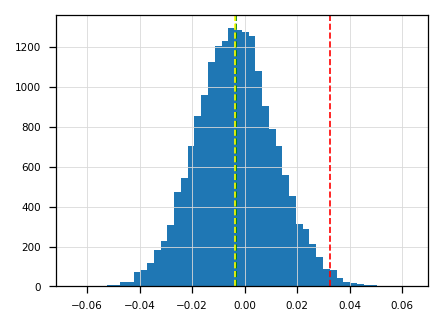

In [37]:
all_permutation_scores = pd.Series(permutation_scores.values.flatten())
all_permutation_scores.hist(bins=50)
plt.axvline(percentile_99, color='red', linestyle='--', label='99th Percentile')
plt.axvline(all_permutation_scores.mean(), color='green', linestyle='--', label='Mean')
plt.axvline(all_permutation_scores.median(), color='yellow', linestyle='--', label='Median')
print("Mean:", all_permutation_scores.mean())
print("Median:", all_permutation_scores.median())

In [38]:
permutation_scores

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bin,,,,,,,,,,,,,,,,,,,,,
95,0.008604,0.015245,-0.036738,-0.002670,-0.012658,-0.014582,-0.040033,0.008274,-0.011793,-0.007340,...,-0.015802,-1.563608e-02,-0.009504,0.025912,0.008959,-0.002095,0.002770,0.011452,0.023627,-0.029704
5,0.000745,0.007057,-0.013224,0.013705,0.022986,-0.004411,-0.009891,-0.006320,0.033766,-0.016884,...,-0.004535,-5.339438e-03,-0.010410,-0.005838,-0.026688,0.014487,-0.013320,0.000833,-0.009023,-0.028204
90,0.003370,0.014322,-0.022277,-0.003145,0.011440,-0.014836,-0.004486,-0.000463,-0.014528,-0.000590,...,-0.014723,-1.659059e-02,0.019870,0.004501,0.001890,-0.023942,0.006854,0.006249,-0.006465,-0.006426
20,-0.003685,-0.018055,0.003217,-0.012282,-0.000865,-0.022079,0.010140,-0.014914,-0.002430,-0.008398,...,0.008981,1.143388e-02,-0.001106,-0.001431,0.008840,-0.009076,-0.000777,0.002801,-0.015084,-0.033860
50,-0.038842,-0.003578,-0.015776,-0.039381,0.012433,-0.010325,0.018023,0.003710,0.017079,0.006138,...,0.046842,-1.145510e-02,-0.038679,-0.015967,-0.017603,-0.016895,0.001803,0.000087,0.003249,-0.003599
80,0.009410,-0.003107,0.002066,-0.006190,0.005328,-0.023337,-0.027272,0.001113,0.016094,-0.000426,...,-0.014585,4.361561e-02,-0.023682,-0.025575,-0.017998,-0.025031,-0.026274,-0.005925,0.016482,-0.046456
60,0.010527,0.016745,0.008924,-0.010294,0.027560,-0.026740,-0.020866,-0.023594,-0.014257,-0.021049,...,0.002804,1.073269e-02,0.014094,-0.014407,0.010861,-0.008067,-0.007549,-0.033530,-0.013198,-0.021675
10,0.001713,-0.011952,-0.003027,-0.008241,-0.017046,-0.006174,-0.001402,-0.009626,0.010577,0.005235,...,0.011786,3.333532e-02,-0.014653,-0.007114,0.008164,-0.004235,-0.003476,-0.019881,0.002278,-0.010620
30,-0.004655,-0.040076,0.002608,-0.010700,-0.004671,0.023598,-0.000076,-0.012846,0.016214,-0.011749,...,0.005133,-1.658787e-02,-0.018786,0.004047,-0.002789,-0.005533,-0.006925,0.011932,-0.018169,-0.011072


IndexError: list index out of range

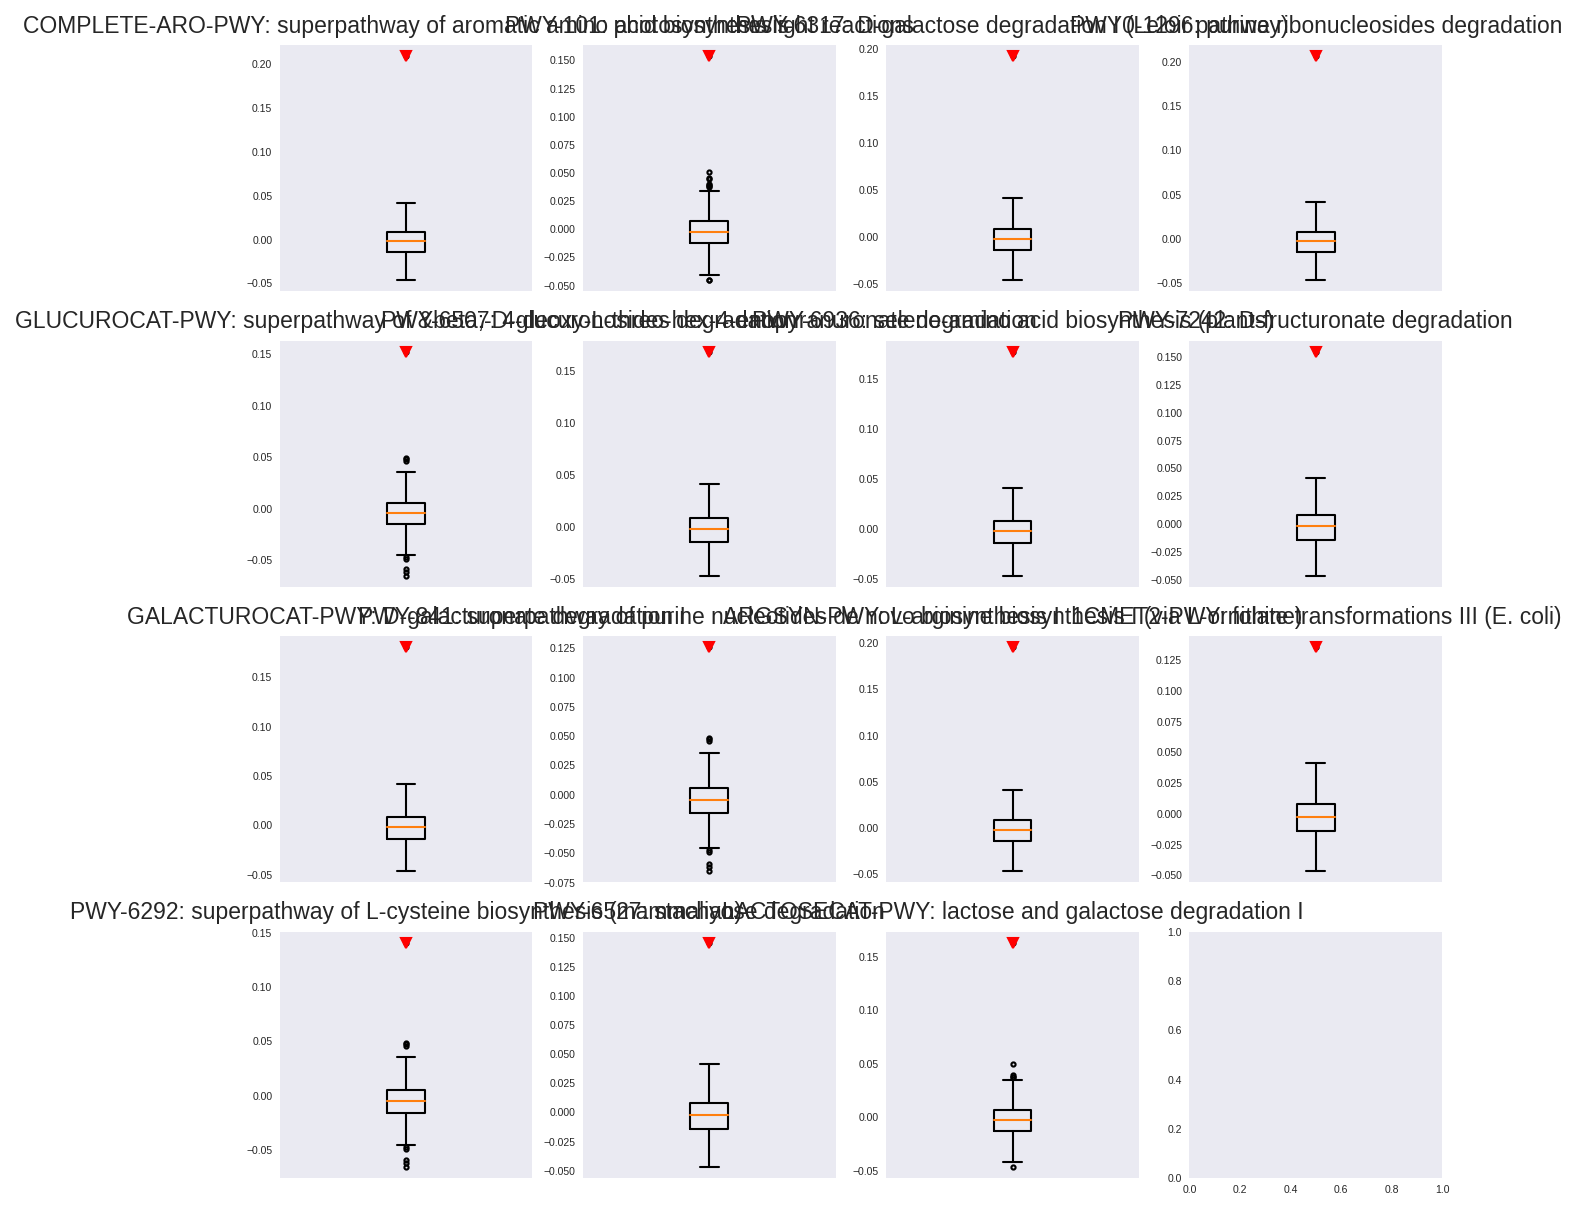

In [39]:
series_list = []
microbe_name_list = []

for microbe_index in top_microbes.index:
    bin = microbe_bin_mapping[targets_reformatted[microbe_index]]
    mic_perm_scores = permutation_scores.loc[bin]
    true_score = lgbm_diet_scores.loc[microbe_index]
    mic_scores = pd.concat([mic_perm_scores, pd.Series([true_score])], ignore_index=True)
    series_list.append(mic_scores)
    microbe_name_list.append(targets[microbe_index])

# Plotting
plt.style.use('seaborn-dark')
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        axs[i, j].boxplot(series_list[i * 4 + j], flierprops=dict(markersize=2))
        true_score = series_list[i * 4 + j].iloc[-1]
        axs[i, j].plot(1, true_score, 'rv', markersize=5)
        axs[i, j].set_xticks([])
        axs[i, j].set_title(microbe_name_list[i * 4 + j], fontsize=11)

plt.tight_layout()
plt.show()

plt.style.use('default')

In [50]:
plt.style.use('default')

In [40]:

# 1. Create a results DataFrame with true scores and their corresponding bins
microbes_perm_scores = pd.DataFrame({'true_score': lgbm_diet_scores})
microbes_perm_scores.index = targets_reformatted
microbes_perm_scores['bin'] = microbes_perm_scores.index.map(microbe_bin_mapping)


# 2. Define a function to calculate the p-value for a single microbe (row)
def calculate_p_value(row):
    # Get the true score and bin for the microbe
    true_score = row['true_score']
    bin_id = row['bin']

    # Get the entire row of permutation scores for that bin
    perm_scores_for_bin = permutation_scores.loc[bin_id].values
    
    # Count how many permutation scores are >= the true score
    count_extreme = np.sum(perm_scores_for_bin >= true_score)
    
    # Get the total number of permutations
    total_permutations = len(perm_scores_for_bin)
    
    # Calculate the p-value using the (k+1)/(n+1) formula
    p_value = (count_extreme + 1) / (total_permutations + 1)
    
    return p_value


# 3. Apply the function to each row to calculate all p-values
microbes_perm_scores['p_value'] = microbes_perm_scores.apply(calculate_p_value, axis=1)

# 1. Define the FDR level (alpha)
fdr_level = 0.05

# 2. Apply the Benjamini/Hochberg FDR correction
reject, q_values, _, _ = multipletests(
    microbes_perm_scores['p_value'], 
    alpha=fdr_level, 
    method='fdr_bh'
)

# 3. Add the results back to your DataFrame
microbes_perm_scores['q_value'] = q_values
microbes_perm_scores['is_significant_fdr'] = reject # 'reject' is a boolean array (True/False)

# 4. Get the final list of significant targets after FDR correction
significant_targets_fdr = microbes_perm_scores[microbes_perm_scores['is_significant_fdr']].index.tolist()

# Display the results
print(f"Found {len(significant_targets_fdr)} significant targets after FDR adjustment (q < {fdr_level})")
print(significant_targets_fdr)

# You can also view the top results sorted by q-value
print("\n--- Results Summary with FDR ---")
print(microbes_perm_scores.sort_values('q_value').head())
print(microbes_perm_scores.sort_values('q_value').tail(10))

Found 313 significant targets after FDR adjustment (q < 0.05)
['1CMET2_PWY__folate_transformations_III__E__coli_', 'ALLANTOINDEG_PWY__superpathway_of_allantoin_degradation_in_yeast', 'ANAEROFRUCAT_PWY__homolactic_fermentation', 'ANAGLYCOLYSIS_PWY__glycolysis_III__from_glucose_', 'ARG_POLYAMINE_SYN__superpathway_of_arginine_and_polyamine_biosynthesis', 'ARGININE_SYN4_PWY__L_ornithine_biosynthesis_II', 'ARGSYN_PWY__L_arginine_biosynthesis_I__via_L_ornithine_', 'ARGSYNBSUB_PWY__L_arginine_biosynthesis_II__acetyl_cycle_', 'ARO_PWY__chorismate_biosynthesis_I', 'ASPASN_PWY__superpathway_of_L_aspartate_and_L_asparagine_biosynthesis', 'AST_PWY__L_arginine_degradation_II__AST_pathway_', 'BIOTIN_BIOSYNTHESIS_PWY__biotin_biosynthesis_I', 'BRANCHED_CHAIN_AA_SYN_PWY__superpathway_of_branched_chain_amino_acid_biosynthesis', 'CALVIN_PWY__Calvin_Benson_Bassham_cycle', 'CENTFERM_PWY__pyruvate_fermentation_to_butanoate', 'CITRULBIO_PWY__L_citrulline_biosynthesis', 'COA_PWY_1__superpathway_of_coenzyme_A_

In [41]:
# # p value cutoff for p < 0.01
# microbes_perm_scores["true_scores"] = lgbm_diet_scores
# microbes_perm_scores['true_is_max'] = microbes_perm_scores.apply(lambda row: row['true_scores'] >= max(row.drop('true_scores')), axis=1)
# microbes_perm_scores['true_is_max'].sum()

In [42]:
# significant_targets = [target for target, m in zip(targets, microbes_perm_scores['true_is_max']) if m]
# print(targets)
# print(significant_targets)


In [43]:
# significant_targets_index = [index for index, (target, m) in enumerate(zip(targets, microbes_perm_scores['true_is_max'])) if m]
# print(targets)
# print(significant_targets_index)


In [44]:
indices = [targets_reformatted.index(item) for item in significant_targets_fdr]
significant_targets = [targets[i] for i in indices]
significant_targets

['1CMET2-PWY: folate transformations III (E. coli)',
 'ALLANTOINDEG-PWY: superpathway of allantoin degradation in yeast',
 'ANAEROFRUCAT-PWY: homolactic fermentation',
 'ANAGLYCOLYSIS-PWY: glycolysis III (from glucose)',
 'ARG+POLYAMINE-SYN: superpathway of arginine and polyamine biosynthesis',
 'ARGININE-SYN4-PWY: L-ornithine biosynthesis II',
 'ARGSYN-PWY: L-arginine biosynthesis I (via L-ornithine)',
 'ARGSYNBSUB-PWY: L-arginine biosynthesis II (acetyl cycle)',
 'ARO-PWY: chorismate biosynthesis I',
 'ASPASN-PWY: superpathway of L-aspartate and L-asparagine biosynthesis',
 'AST-PWY: L-arginine degradation II (AST pathway)',
 'BIOTIN-BIOSYNTHESIS-PWY: biotin biosynthesis I',
 'BRANCHED-CHAIN-AA-SYN-PWY: superpathway of branched chain amino acid biosynthesis',
 'CALVIN-PWY: Calvin-Benson-Bassham cycle',
 'CENTFERM-PWY: pyruvate fermentation to butanoate',
 'CITRULBIO-PWY: L-citrulline biosynthesis',
 'COA-PWY-1: superpathway of coenzyme A biosynthesis III (mammals)',
 'COA-PWY: coenzy

In [46]:
with open(home_path + 'data/regression/segal_species/significant_targets_pathways.pkl', 'wb') as file:
    pickle.dump(significant_targets, file)

In [47]:
len(targets)

320

## Plots

#### Overall results for Eran

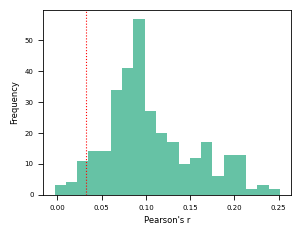

In [51]:
plt.style.use(single_style)
plt.figure()
plt.hist(lgbm_diet_scores, bins=20, color=palette[0])
plt.xlabel("Pearson's r")
plt.ylabel("Frequency")
plt.axvline(percentile_99, color='red', linestyle='dotted', linewidth=0.8, label="Permutations\n99th percentile")
plt.savefig(home_path + "figures/regression/pathways/pathways_corr_distribution.png", 
            dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.savefig(home_path + "figures/regression/pathways/pathways_corr_distribution.pdf", 
            dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')
plt.show()

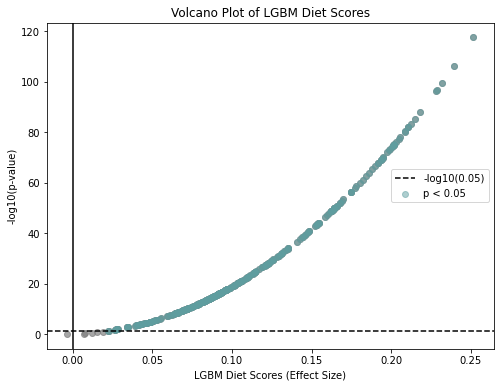

In [77]:
neg_log_pvalues = -np.log10(lgbm_diet_pvalues)

# Creating the volcano plot
plt.figure(figsize=(8, 6))
plt.scatter(lgbm_diet_scores, neg_log_pvalues, c='gray', alpha=0.7)

# Highlight significant points
sig_threshold = 0.05
highly_significant = lgbm_diet_pvalues < sig_threshold
plt.scatter(
    lgbm_diet_scores[highly_significant], 
    neg_log_pvalues[highly_significant], 
    color='cadetblue', 
    alpha=0.5,
    label=f'p < {sig_threshold}'
)

# Adding labels and reference lines
plt.axhline(-np.log10(sig_threshold), color='black', linestyle='--', label=f'-log10({sig_threshold})')
plt.axvline(0, color='black', linestyle='-')
plt.xlabel("LGBM Diet Scores (Effect Size)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot of LGBM Diet Scores")
plt.legend()
plt.show()

#### How do Ridge and LGBM scores compare?

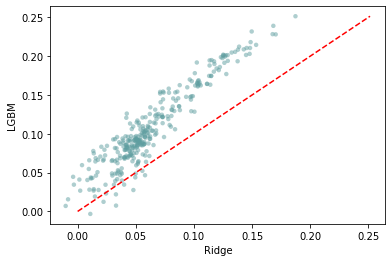

<Figure size 432x288 with 0 Axes>

In [78]:
%matplotlib inline
U, p = stats.mannwhitneyu(ridge_diet_scores, lgbm_diet_scores, alternative='two-sided')
to_plot = pd.concat([ridge_diet_scores, lgbm_diet_scores] , axis=1)
to_plot.columns = ["Ridge", "LGBM"]
to_plot.plot.scatter("Ridge", "LGBM", alpha=0.5, color='cadetblue', edgecolors='none')
# plt.title("Pearson Correlation Ridge VS LGBM")
plt.plot([0, lgbm_diet_scores.max()], [0, lgbm_diet_scores.max()], 'r--')
# plt.grid()
# plt.text(0.45, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
plt.savefig(home_path + "figures/regression/pathways/ridge_vs_lgbm_scatter.pdf", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')
plt.show()
plt.clf()

### How do age and gender compare?

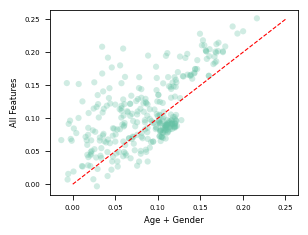

<Figure size 320x240 with 0 Axes>

In [52]:
U, p = stats.mannwhitneyu(lgbm_base_scores, lgbm_diet_scores, alternative='two-sided')

# Assemble and clean
to_plot = pd.concat([lgbm_base_scores, lgbm_diet_scores], axis=1).dropna()
to_plot.columns = ["Age + Gender", "All Features"]

# Pearson r for annotation
r_val = to_plot["Age + Gender"].corr(to_plot["All Features"], method="pearson")

# Scatter with the same style: color1, alpha=0.3, no edgecolor
to_plot.plot.scatter(
    "Age + Gender",
    "All Features",
    color=palette[0],
    alpha=0.3,
    edgecolor="none"
)

# plt.title("Abundances Targets")
plt.plot([0, lgbm_diet_scores.max()], [0, lgbm_diet_scores.max()], 'r--')
# plt.grid()
# plt.text(0.5, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), f'p-value: {p:.2f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
plt.savefig(home_path + "figures/regression/pathways/lgbm_base_diet_scatter.png", 
            dpi=400, facecolor="white", transparent=False, bbox_inches='tight')
plt.savefig(home_path + "figures/regression/pathways/lgbm_base_diet_scatter.pdf", 
            dpi=400, facecolor="white", transparent=False, bbox_inches='tight', format='pdf')
plt.show()
plt.clf()

#### What is the corr diference between the highly predicted microbes in LGBM and Ridge?
Maybe those with high signal will show a significant difference between the models.

In [80]:
highly_pred_microbes_lgbm = lgbm_diet_scores.sort_values(ascending=False)
highly_pred_microbes_lgbm = highly_pred_microbes_lgbm[highly_pred_microbes_lgbm > 0.2]
highly_pred_microbes_lgbm

310    0.251534
152    0.239180
172    0.231900
231    0.228448
57     0.228161
232    0.218177
319    0.214633
61     0.212333
154    0.210643
155    0.210631
160    0.208855
20     0.208432
276    0.205673
109    0.204740
251    0.203072
173    0.201959
149    0.201627
9      0.201476
95     0.201417
89     0.201179
226    0.200266
Name: 0, dtype: float64

In [81]:
high_pred_targets = [targets[i] for i in highly_pred_microbes_lgbm.index]
high_pred_targets

['SER-GLYSYN-PWY: superpathway of L-serine and glycine biosynthesis I',
 'PWY-6121: 5-aminoimidazole ribonucleotide biosynthesis I',
 'PWY-6385: peptidoglycan biosynthesis III (mycobacteria)',
 'PWY-7237: myo-, chiro- and scyllo-inositol degradation',
 'HISDEG-PWY: L-histidine degradation I',
 'PWY-7238: sucrose biosynthesis II',
 'VALSYN-PWY: L-valine biosynthesis',
 'ILEUSYN-PWY: L-isoleucine biosynthesis I (from threonine)',
 "PWY-6123: inosine-5'-phosphate biosynthesis I",
 "PWY-6124: inosine-5'-phosphate biosynthesis II",
 'PWY-6151: S-adenosyl-L-methionine salvage I',
 'COMPLETE-ARO-PWY: superpathway of aromatic amino acid biosynthesis',
 'PWY0-1296: purine ribonucleosides degradation',
 'PWY-5103: L-isoleucine biosynthesis III',
 'PWY-7663: gondoate biosynthesis (anaerobic)',
 'PWY-6386: UDP-N-acetylmuramoyl-pentapeptide biosynthesis II (lysine-containing)',
 'PWY-5973: cis-vaccenate biosynthesis',
 'ASPASN-PWY: superpathway of L-aspartate and L-asparagine biosynthesis',
 'PWY-1

In [82]:
# For summary plot
list(highly_pred_microbes_lgbm.index)

[310,
 152,
 172,
 231,
 57,
 232,
 319,
 61,
 154,
 155,
 160,
 20,
 276,
 109,
 251,
 173,
 149,
 9,
 95,
 89,
 226]

In [83]:
# High pred gain
high_pred_gain_targets = [targets[i] for i in top_microbes.index]
high_pred_gain_targets

['COMPLETE-ARO-PWY: superpathway of aromatic amino acid biosynthesis',
 'PWY-101: photosynthesis light reactions',
 'PWY-6317: D-galactose degradation I (Leloir pathway)',
 'PWY0-1296: purine ribonucleosides degradation',
 'GLUCUROCAT-PWY: superpathway of &beta;-D-glucuronosides degradation',
 'PWY-6507: 4-deoxy-L-threo-hex-4-enopyranuronate degradation',
 'PWY-6936: seleno-amino acid biosynthesis (plants)',
 'PWY-7242: D-fructuronate degradation',
 'GALACTUROCAT-PWY: D-galacturonate degradation I',
 'PWY-841: superpathway of purine nucleotides de novo biosynthesis I',
 'ARGSYN-PWY: L-arginine biosynthesis I (via L-ornithine)',
 '1CMET2-PWY: folate transformations III (E. coli)',
 'PWY-6292: superpathway of L-cysteine biosynthesis (mammalian)',
 'PWY-6527: stachyose degradation',
 'LACTOSECAT-PWY: lactose and galactose degradation I']

#### Robustness Check

Abundance:

In [84]:
def read_robustness(TARGETS):

    MODEL = 'LGBM' # 'LGBM' or 'ridge'
    STAGE = 'baseline' # 'baseline' or '02_visit'
    # suffix = '_all_baseline' if SPLIT == 'all_baseline' else '' 
    PROBLEM = '' # 'classification' or '' for regression
    robustness_results = []

    test_02_visit = pd.read_pickle(home_path + "data/diet_mb_02_visit.pkl")
        
    baseline_subjects = list(diet_mb.index)
    visit_subjects = list(test_02_visit.index)
    print("Length of baseline_subjects:", len(baseline_subjects))
    print("Length of visit_subjects:", len(visit_subjects))
    test_baseline = diet_mb.loc[diet_mb.index.isin(visit_subjects)]
    test_02_visit = test_02_visit.loc[test_02_visit.index.isin(test_baseline.index)]
    print(test_baseline.shape)  
    print(test_02_visit.shape) 
    # test_baseline is my holdout set 
    current_df = diet_mb.loc[~diet_mb.index.isin(visit_subjects)].copy()

    n_samples = len(current_df)
    samples = []

    iteration = 1
    while n_samples > 1:
        samples.append(n_samples)
        print(f"Iteration {iteration}: {n_samples} samples")
        loaded = pickle.load(open(home_path + "data/robustness/output_" + MODEL + '_' + TARGETS + '_' + str(n_samples) + '_samples' + PROBLEM + '.pkl', "rb"))
        robustness_results.append(loaded)
        # Reduce samples by half for the next iteration
        n_samples = math.ceil(n_samples / 2)  # Use math.ceil to ensure at least one sample
        current_df = current_df.sample(n=n_samples, random_state=iteration).reset_index(drop=True)
        iteration += 1

    return robustness_results, samples


def robustness_calc(robustness_results, samples, TARGETS):
    if TARGETS == "div":
        print("div")
        robustness_scores_richness = []
        robustness_scores_shannon = []
        for result in robustness_results:
            robustness_scores, robustness_pvalues, robustness_coefs, robustness_preds, robustness_targets = read_results(result)
            robustness_scores_richness.append(robustness_scores[0])
            robustness_scores_shannon.append(robustness_scores[1])

        nan_index = np.isnan(robustness_scores_richness).argmax()
        robustness_scores_richness = robustness_scores_richness[:nan_index]
        robustness_scores_shannon = robustness_scores_shannon[:nan_index]
        samples = samples[:nan_index]

        iterations = list(range(1, nan_index + 1))

        return robustness_scores_richness, robustness_scores_shannon, iterations, samples

    elif TARGETS == "abundance":
        print("abundance")
        robustness_means = []
        robustness_stds = []
        for result in robustness_results:
            robustness_scores, robustness_pvalues, robustness_coefs, robustness_preds, robustness_targets = read_results(result)
            robustness_means.append(robustness_scores.mean())
            robustness_stds.append(robustness_scores.std())


        nan_index = np.isnan(robustness_means).argmax()
        robustness_means = robustness_means[:nan_index]
        robustness_stds = robustness_stds[:nan_index]
        samples = samples[:nan_index]

        iterations = list(range(1, nan_index + 1))

        return robustness_means, robustness_stds, iterations, samples


In [85]:
robustness_results, samples = read_robustness("abundance")
robustness_means, robustness_stds, iterations, samples = robustness_calc(robustness_results, samples, "abundance")

print(robustness_means)
print(robustness_stds)
print(iterations)
print(samples)

FileNotFoundError: [Errno 2] No such file or directory: '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/diet_mb_02_visit.pkl'

In [ ]:
# Abundance

def plot_robustness_pathways(robustness_means, robustness_stds, samples):
    # Plot mean with standard deviations as error bars
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        samples,
        robustness_means,
        yerr=robustness_stds,
        fmt='-o',
        capsize=5,
        label="Mean Pearson Correlations",
        # ecolor='black', 
        color='cadetblue'
    )

    # Formatting
    # plt.title("Mean Pearson Correlations per Number of Subjects")
    plt.xlabel("Number of Subjects per Iteration", fontsize=14)
    plt.ylabel("Mean Pearson Correlation ± STD", fontsize=14)
    # plt.xscale("log")  # Log scale for better visibility
    plt.xticks(samples, rotation=90)
    plt.grid(alpha=0.5, linestyle='--')
    # plt.legend()

    # Show plot
    plt.tight_layout()
    plt.savefig(home_path + "figures/regression/pathways/abundance_robustness.pdf", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')
    plt.show()


plot_robustness_pathways(robustness_means, robustness_stds, samples)

NameError: name 'robustness_means' is not defined

Diversity:

In [ ]:
robustness_results, samples = read_robustness("div")
robustness_scores_richness, robustness_scores_shannon, iterations, samples = robustness_calc(robustness_results, samples, "div")

print(robustness_scores_richness)
print(robustness_scores_shannon)
print(iterations)
print(samples)

Length of baseline_subjects: 8449
Length of visit_subjects: 2493
(2320, 1582)
(2320, 1548)
Iteration 1: 6129 samples


FileNotFoundError: [Errno 2] No such file or directory: '/net/mraid20/export/genie/LabData/Analyses/tomerse/test/robustness/output_LGBM_div_6129_samples.pkl'

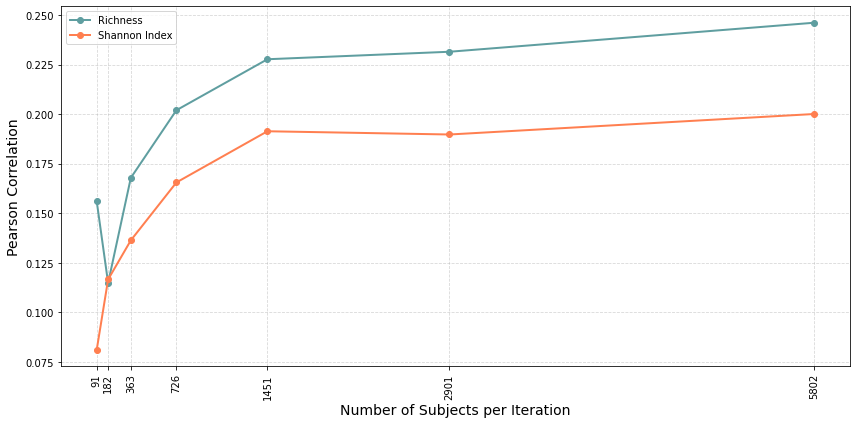

In [ ]:
# Abundance

def plot_robustness_div(robustness_scores_richness, robustness_scores_shannon, samples):
    plt.figure(figsize=(12, 6))
    
    # Plot the two lines
    plt.plot(samples, robustness_scores_richness, label="Richness", marker='o', linestyle='-', linewidth=2, color='cadetblue')
    plt.plot(samples, robustness_scores_shannon, label="Shannon Index", marker='o', linestyle='-', linewidth=2, color='coral')
    
    # Formatting
    # plt.title("Diversity Pearson's Correlations per Number of Subjects")
    plt.xlabel("Number of Subjects per Iteration", fontsize=14)
    plt.ylabel("Pearson Correlation", fontsize=14)
    plt.xticks(samples, rotation=90)
    plt.grid(alpha=0.5, linestyle='--')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.savefig(home_path + "figures/regression/pathways/diversity_robustness.pdf", dpi=300, facecolor="white", transparent=False, bbox_inches='tight')
    plt.show()
    

plot_robustness_div(robustness_scores_richness, robustness_scores_shannon, samples)